In [223]:
import pandas as pd
import numpy as np
import seaborn as sns

In [225]:
df = pd.read_csv('abalone_clean.csv', index_col=0)

In [227]:
df

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.7985,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


У нас есть предобработанный датасет, и мы можем приступить к построению некоторых моделей.

Начнем с простой линейной регрессии для предсказания.

In [231]:
X = df[['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight']] # возьмем все числовые признаки
y = df[['Rings']] # целевая переменная

from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X, y)

pred = lr.predict(X)

Посмотрим на ошибку модели: 

In [234]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y, pred), np.mean(y)

(1.6519445063096707, 9.933684462532918)

То есть наша модель может ошибаться на 1.652 в обе стороны от истинного значения.

<Axes: xlabel='Rings', ylabel='Count'>

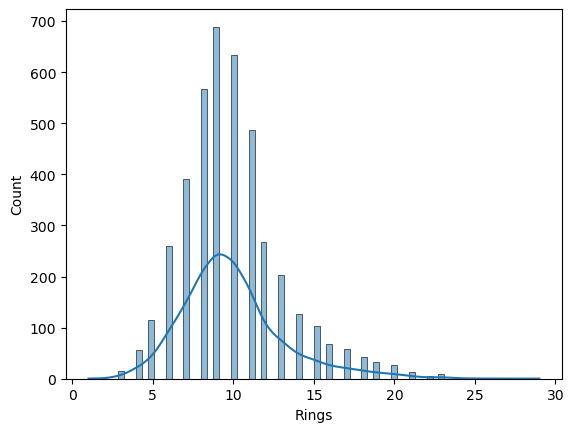

In [237]:
sns.histplot(data=df['Rings'], kde=True)

Распределение целевой переменной не имеет тяжелого хвоста, поэтому разделять данные мы не будем.

Хотя GaussianNB не предназначен для предсказания непрерывных значений, все же взглянем на него: 

In [240]:
X = df[['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight']] # возьмем все числовые признаки
y = df[['Rings']] # целевая переменная

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42) # делим данные на тестовые и тренировочные

from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB() # объявляем модель
gnb.fit(X_train, y_train) # обучаем

pred_nb = gnb.predict(X_test) # предсказываем

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Вычислим долю правильных предсказаний:

In [243]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, pred_nb)

0.23827751196172248

Мы наблюдаем очень плохой показатель, потому что данный метод нам не подохдит. Мы имеет дело с непрерывным значением, поэтому далее построим KNN - метод k ближайших соседей для задачи регрессии.

In [246]:
from sklearn.neighbors import KNeighborsRegressor

knn_r = KNeighborsRegressor()
knn_r.fit(X_train, y_train)
pred_knn = knn_r.predict(X_test)

In [248]:
mean_absolute_error(y_test, pred_knn)

1.5779904306220096

Показатель стал чуть лучше, чем у модели линейной регрессии. Разобьем данные с помощью кросс-владилации для нашей модели:

In [251]:
from sklearn.model_selection import cross_val_score

cross_val_score(knn_cl, X, y, scoring='neg_mean_absolute_error', cv=3, n_jobs=-1).mean()

-1.6249463312732244

Показатель стал чуть хуже, чем на train_test_split данных. Попробуем задать гиперпараметры для нашей модели и снова оценить качество.

Подберем гиперпараметры в ручную. Для этого нам необходимо разбить данные на три части: train, validation, test. 

In [255]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [257]:
best_k = -1
best_mae = float('inf')

for k in np.arange(2, 30, 1):
    knn_r = KNeighborsRegressor(n_neighbors=k)

    knn_r.fit(X_train, y_train)
    pred_knn_r = knn_r.predict(X_val)
    mae = mean_absolute_error(y_val, pred_knn_r)

    if mae < best_mae:  # Нам нужно минимальное значение MAE
        best_k = k
        best_mae = mae

    print('n_neighbors:', k, 'mae:', mae)

print(best_k, best_mae)

n_neighbors: 2 mae: 1.7541507024265646
n_neighbors: 3 mae: 1.710089399744572
n_neighbors: 4 mae: 1.6775223499361431
n_neighbors: 5 mae: 1.6326947637292466
n_neighbors: 6 mae: 1.5985525755640697
n_neighbors: 7 mae: 1.5738004013866083
n_neighbors: 8 mae: 1.5576309067688379
n_neighbors: 9 mae: 1.571306939123031
n_neighbors: 10 mae: 1.5767560664112388
n_neighbors: 11 mae: 1.5691396725879483
n_neighbors: 12 mae: 1.564282673478076
n_neighbors: 13 mae: 1.5618430101188725
n_neighbors: 14 mae: 1.561576354679803
n_neighbors: 15 mae: 1.5658578118348232
n_neighbors: 16 mae: 1.5561941251596425
n_neighbors: 17 mae: 1.554203290511607
n_neighbors: 18 mae: 1.557116503476657
n_neighbors: 19 mae: 1.5549505948779994
n_neighbors: 20 mae: 1.5491060025542782
n_neighbors: 21 mae: 1.549534756431308
n_neighbors: 22 mae: 1.5460350632764426
n_neighbors: 23 mae: 1.5461713587650618
n_neighbors: 24 mae: 1.5444338016177097
n_neighbors: 25 mae: 1.5436015325670496
n_neighbors: 26 mae: 1.549169859514687
n_neighbors: 27 

Теперь попробуем подбор гиперпараметров по сетке с помощью GridSearchCV:

In [260]:
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

model = KNeighborsRegressor()

params = {'n_neighbors' : np.arange(2, 30, 2),
          'weights' : ['uniform', 'distance'],
          'p' : [1, 2]}

gs = GridSearchCV (model, params, scoring='neg_mean_absolute_error', cv=3, n_jobs=-1, verbose=2)
gs.fit(X_train, y_train)

Fitting 3 folds for each of 56 candidates, totalling 168 fits


GridSearchCV(cv=3, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]),
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             scoring='neg_mean_absolute_error', verbose=2)

In [262]:
gs.best_score_, gs.best_params_

(-1.5383693164794672, {'n_neighbors': 24, 'p': 1, 'weights': 'distance'})

GridSearchCV надежнее в вычислении наилучших гиперпараматеров, поэтому будем использовать его значения для дальнейшего прогноза.

In [265]:
pred = gs.best_estimator_.predict(X_test)

mean_absolute_error(y_test, pred)

1.4871228661993952

С гиперпараметрами мы улучшили качество нашей модели, снизив значение абсолютной ошибки.

У нас есть всего лишь один категориальный признак. Добавим его, обучим модель заново и оценим качество.

In [275]:
X_full = df.drop('Rings', axis=1)

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y, test_size=0.25, random_state=42)

In [277]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

categorical = ['Sex']
numeric_features = ['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight']

ct = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', MinMaxScaler(), numeric_features)
])

X_train_transformed = ct.fit_transform(X_train_full)
X_test_transformed = ct.transform(X_test_full)

In [279]:
new_features = list(ct.named_transformers_['ohe'].get_feature_names_out())
new_features.extend(numeric_features)

new_features

['Sex_F',
 'Sex_I',
 'Sex_M',
 'Length',
 'Diameter',
 'Height',
 'Whole weight',
 'Shucked weight',
 'Viscera weight',
 'Shell weight']

In [281]:
X_train_transformed = pd.DataFrame(X_train_transformed, columns=new_features)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=new_features)

X_train_transformed.head()

,Sex_F,Sex_I,Sex_M,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight
0,1.0,0.0,0.0,0.729730,0.672269,0.119469,0.374358,0.317754,0.345622,0.271550
1,1.0,0.0,0.0,0.594595,0.571429,0.123894,0.242253,0.188299,0.164582,0.217738
2,0.0,0.0,1.0,0.790541,0.798319,0.154867,0.559943,0.496638,0.460829,0.402093
3,0.0,0.0,1.0,0.513514,0.521008,0.084071,0.181335,0.150303,0.132324,0.147982
4,0.0,0.0,1.0,0.567568,0.579832,0.137168,0.285638,0.157028,0.151415,0.347285


In [283]:
model = KNeighborsRegressor()

params = {'n_neighbors' : np.arange(2, 30, 2),
          'weights' : ['uniform', 'distance'],
          'p' : [1, 2]}

gs = GridSearchCV (model, params, scoring='neg_mean_absolute_error', cv=3, n_jobs=-1, verbose=2)
gs.fit(X_train_transformed, y_train_full)

Fitting 3 folds for each of 56 candidates, totalling 168 fits


GridSearchCV(cv=3, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]),
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             scoring='neg_mean_absolute_error', verbose=2)

In [285]:
gs.best_score_, gs.best_params_

(-1.572305828138781, {'n_neighbors': 16, 'p': 1, 'weights': 'distance'})

In [289]:
pred = gs.best_estimator_.predict(X_test_transformed)

mean_absolute_error(y_test_full, pred)

1.4937878639288114

Добавление категориального признака почти не изменило качество модели, поэтому мы можем сделать вывод, что Sex особо не влияет на целевую переменную.

<Axes: xlabel='Sex', ylabel='Rings'>

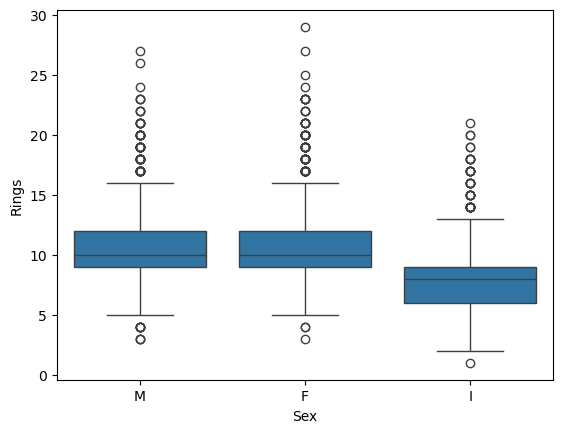

In [292]:
sns.boxplot(x=df['Sex'], y=df['Rings'])

Перейдем к построение дашборда:

In [297]:
!pip install explainerdashboard

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/7.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/7.8 MB ? eta -:--:--
   ---- ----------------------------------- 0.8/7.8 MB 1.2 MB/s eta 0:00:06
   ----- ---------------------------------- 1.0/7.8 MB 1.4 MB/s eta 0:00:05
   ------ --------------------------------- 1.3/7.8 MB 1.4 MB/s eta 0:00:05
   --------- ------------------------------ 1.8/7.8 MB 1.5 MB/s eta 0:00:05
   ---------- ----------------------------- 2.1/7.8 MB 1.6 MB/s eta 0:00:04
   ------------- -------------------------- 2.6/7.8 MB 1.6 MB/s eta 0:00:04
   ----------------- ---------------------- 3.4/7.8 MB 1.9 MB/s eta 0:00:03
   -------------------- ------------------- 3.9/7.8 MB 2.0 MB/s eta 0:00:02
   ------------------------- -------------- 5.0/7.8 MB 2.2 MB/s eta 0:00:02
   ----------------------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [299]:
from explainerdashboard import RegressionExplainer, ExplainerDashboard

In [314]:
explainer = RegressionExplainer(gs.best_estimator_, X_test_transformed.iloc[:200], y_test_full.iloc[:200])

Generating self.shap_explainer = shap.KernelExplainer(model, X)...


In [316]:
db = ExplainerDashboard(explainer)

Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
For this type of model and model_output interactions don't work, so setting shap_interaction=False...
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...


  0%|          | 0/200 [00:00<?, ?it/s]

Calculating predictions...
Calculating residuals...
Calculating absolute residuals...
Calculating dependencies...
Calculating importances...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...


In [318]:
db.run(port=8050, host="localhost")

Starting ExplainerDashboard on http://192.168.1.36:8050


In [322]:
db.to_yaml("dashboard.yaml")

Dumping configuration .yaml to C:\Users\Алена\dashboard.yaml...


Проанализируем наш дашборд:

На первой вкладке мы можем посомтреть на признаки наших данных и их влияние на предсказание целевой переменной. Наиболее важным признаком является shell weight при прогнозе возраста ушка, также мы видим, что Sex и Height являюст маловажными. 
На второй вкладке можно взглянуть на различные метрики, включая mean_absolute_error, которую мы считали при построении модели регрессии. Значение схоже с нашим, подсчитанным в ручную, потому что дашборд мы строили не на всех данных, дабы уменьшить нагрузку и время.

Взглянем на индвидиальные значения и их прогнозы: 
Например, строчка с индексом 37. Возраст, предсказанный моделью составляет 3.672, а реальный возраст 3.000. Не такой плохой результат. Ниже мы можем увидеть график и описание того, почему модель так решила. Например, такие признаки как Length и Diametr повлияли на оценку возраста в меньшую сторону. 

Строчка с индексом 11. Возраст, предсказанный моделью - 7.271, реальный - 7.000. Совсем небольшая разница. Отличный результат.

